# Set up

In [1]:
import torch
import torch.nn.functional as F
import os
import subprocess
import sys
from PIL import Image
from torchvision import utils, transforms,models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
from torch import optim
import copy
import time
from tqdm.notebook import tqdm
import random
import json
import copy
from sklearn.metrics import classification_report

In [2]:
def preview_local_images(path_list):
    """
    Fetches and displays one sample image from each local path.
    path_list: list of tuples (label, path) or list of paths
    """
    num_paths = len(path_list)
    plt.figure(figsize=(15, 5))

    for i, item in enumerate(path_list):
        # Handle both tuple (label, path) and plain path
        if isinstance(item, tuple):
            label, path = item
        else:
            path = item
            label = os.path.basename(path)

        ax = plt.subplot(1, num_paths, i + 1)
        patterns_to_check = [".png", ".jpg", ".jpeg"]
        file_list = []

        for root, _, files in os.walk(path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in patterns_to_check):
                    file_list.append(os.path.join(root, file))

        if not file_list:
            print(f"No image files found in {file_list}")
            continue

        sample_file_path = file_list[0]

        try:
            image = Image.open(sample_file_path).convert('RGB')
            ax.imshow(image)
            ax.set_title(f"Class: {label}\n{os.path.basename(sample_file_path)}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {sample_file_path}: {e}")
            ax.set_title(f"Error loading {label}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Image Preprocessing

In [3]:
class ImageDataset(Dataset):
    """
    Custom PyTorch Dataset for Mean Teacher domain adaptation.
    Supports both labeled source domain and unlabeled target domain with dual augmentations.
    """
    def __init__(self, file_paths, labels, transform=None, return_dual_augmentation=False):
        """
        Args:
            file_paths (list): List of local file paths to images.
            labels (list): List of corresponding labels (0 or 1).
            transform (torchvision.transforms, optional): Transformations to apply to the image.
            return_dual_augmentation (bool): If True, returns two augmented views (for Mean Teacher on target domain).
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.return_dual_augmentation = return_dual_augmentation

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Returns (image_tensor, label_tensor, local_path) for normal mode
        Returns (image_tensor1, image_tensor2, label_tensor, local_path) for dual augmentation mode
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        local_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(local_path).convert('RGB')

            if self.return_dual_augmentation:
                # For target domain training: return two different augmentations + label (for evaluation)
                if self.transform:
                    image_tensor1 = self.transform(image)
                    image_tensor2 = self.transform(image)
                else:
                    to_tensor = transforms.ToTensor()
                    image_tensor1 = to_tensor(image)
                    image_tensor2 = to_tensor(image)
                return image_tensor1, image_tensor2, torch.tensor(label, dtype=torch.long), local_path
            else:
                # For source domain or evaluation: return single augmentation + label
                if self.transform:
                    image_tensor = self.transform(image)
                else:
                    image_tensor = transforms.ToTensor()(image)
                return image_tensor, torch.tensor(label, dtype=torch.long), local_path

        except Exception as e:
            print(f"Error loading image {local_path}: {e}")
            dummy_tensor = torch.zeros((3, 224, 224))
            if self.return_dual_augmentation:
                return dummy_tensor, dummy_tensor, torch.tensor(0, dtype=torch.long), "ERROR_LOADING_FILE"
            else:
                return dummy_tensor, torch.tensor(0, dtype=torch.long), "ERROR_LOADING_FILE"

In [4]:
def get_data_mixed_structure(
    source_video_real_paths, source_video_fake_paths,
    target_image_real_paths, target_image_fake_paths,
    source_transform, target_train_transform, eval_transform,
    batch_size, random_seed
):
    """
    Creates datasets and dataloaders for Mean Teacher domain adaptation:
    - Source domain (labeled): Celeb-real, YouTube-real, Celeb-synthesis - split by folder
    - Target domain (unlabeled for training, labeled for eval): FFHQ, StableDiffusion, StyleGAN - split by image

    Args:
        source_video_real_paths: List of paths to source real video folders (Celeb-real, YouTube-real)
        source_video_fake_paths: List of paths to source fake video folders (Celeb-synthesis)
        target_image_real_paths: List of paths to target real image folders (FFHQ-real-v2)
        target_image_fake_paths: List of paths to target fake image folders (StableDiffusion, StyleGAN)
        source_transform: Transform for source domain data
        target_train_transform: Transform for target domain training (dual augmentation)
        eval_transform: Transform for evaluation (both source and target)
        batch_size: Batch size for dataloaders
        random_seed: Random seed for reproducibility

    Returns:
        Dictionary containing DataLoaders:
        - 'source_train_loader': Source domain training (with labels)
        - 'source_val_loader': Source domain validation (with labels)
        - 'source_test_loader': Source domain test (with labels)
        - 'target_train_loader': Target domain training (dual augmentation for Mean Teacher)
        - 'target_val_loader': Target domain validation (with labels for evaluation)
        - 'target_test_loader': Target domain test (with labels for evaluation)
    """

    LABEL_REAL = 0
    LABEL_FAKE = 1
    patterns_to_check = ["*.png", "*.jpg", "*.jpeg"]

    # ========================================
    # PART 1: Handle SOURCE DOMAIN (video-based, split by folder)
    # ========================================
    source_real_folders = defaultdict(list)
    source_fake_folders = defaultdict(list)

    for path in source_video_real_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            for file in files:
                source_real_folders[os.path.dirname(file)].append(file)

    for path in source_video_fake_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            for file in files:
                source_fake_folders[os.path.dirname(file)].append(file)

    # Split source folders
    train_source_real_folders, val_source_real_folders, test_source_real_folders = [], [], []
    train_source_fake_folders, val_source_fake_folders, test_source_fake_folders = [], [], []

    if len(source_real_folders) > 0:
        real_folder_names = sorted(list(source_real_folders.keys()))
        train_source_real_folders, temp_real = train_test_split(
            real_folder_names, test_size=0.3, random_state=random_seed
        )
        val_source_real_folders, test_source_real_folders = train_test_split(
            temp_real, test_size=0.5, random_state=random_seed
        )

    if len(source_fake_folders) > 0:
        fake_folder_names = sorted(list(source_fake_folders.keys()))
        train_source_fake_folders, temp_fake = train_test_split(
            fake_folder_names, test_size=0.3, random_state=random_seed
        )
        val_source_fake_folders, test_source_fake_folders = train_test_split(
            temp_fake, test_size=0.5, random_state=random_seed
        )

    # ========================================
    # PART 2: Handle TARGET DOMAIN (image-based, split by image)
    # ========================================
    target_real_files = []
    target_fake_files = []

    for path in target_image_real_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            target_real_files.extend(files)

    for path in target_image_fake_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            target_fake_files.extend(files)

    # Split target data (keep labels for evaluation)
    train_target_real, temp_target_real = [], []
    val_target_real, test_target_real = [], []
    train_target_fake, temp_target_fake = [], []
    val_target_fake, test_target_fake = [], []

    if len(target_real_files) > 0:
        sorted_target_real = sorted(target_real_files)
        train_target_real, temp_target_real = train_test_split(
            sorted_target_real, test_size=0.3, random_state=random_seed
        )
        val_target_real, test_target_real = train_test_split(
            temp_target_real, test_size=0.5, random_state=random_seed
        )

    if len(target_fake_files) > 0:
        sorted_target_fake = sorted(target_fake_files)
        train_target_fake, temp_target_fake = train_test_split(
            sorted_target_fake, test_size=0.3, random_state=random_seed
        )
        val_target_fake, test_target_fake = train_test_split(
            temp_target_fake, test_size=0.5, random_state=random_seed
        )

    # ========================================
    # PART 3: Combine splits
    # ========================================
    # Source domain
    source_train_files, source_train_labels = [], []
    source_val_files, source_val_labels = [], []
    source_test_files, source_test_labels = [], []

    for folder in train_source_real_folders:
        source_train_files.extend(source_real_folders[folder])
        source_train_labels.extend([LABEL_REAL] * len(source_real_folders[folder]))
    for folder in val_source_real_folders:
        source_val_files.extend(source_real_folders[folder])
        source_val_labels.extend([LABEL_REAL] * len(source_real_folders[folder]))
    for folder in test_source_real_folders:
        source_test_files.extend(source_real_folders[folder])
        source_test_labels.extend([LABEL_REAL] * len(source_real_folders[folder]))

    for folder in train_source_fake_folders:
        source_train_files.extend(source_fake_folders[folder])
        source_train_labels.extend([LABEL_FAKE] * len(source_fake_folders[folder]))
    for folder in val_source_fake_folders:
        source_val_files.extend(source_fake_folders[folder])
        source_val_labels.extend([LABEL_FAKE] * len(source_fake_folders[folder]))
    for folder in test_source_fake_folders:
        source_test_files.extend(source_fake_folders[folder])
        source_test_labels.extend([LABEL_FAKE] * len(source_fake_folders[folder]))

    # Target domain (with labels for evaluation)
    target_train_files = train_target_real + train_target_fake
    target_train_labels = [LABEL_REAL] * len(train_target_real) + [LABEL_FAKE] * len(train_target_fake)

    target_val_files = val_target_real + val_target_fake
    target_val_labels = [LABEL_REAL] * len(val_target_real) + [LABEL_FAKE] * len(val_target_fake)

    target_test_files = test_target_real + test_target_fake
    target_test_labels = [LABEL_REAL] * len(test_target_real) + [LABEL_FAKE] * len(test_target_fake)

    # ========================================
    # PART 4: Create Datasets
    # ========================================
    # Source domain datasets (standard)
    source_train_dataset = ImageDataset(
        source_train_files, source_train_labels,
        transform=source_transform, return_dual_augmentation=False
    )
    source_val_dataset = ImageDataset(
        source_val_files, source_val_labels,
        transform=eval_transform, return_dual_augmentation=False
    )
    source_test_dataset = ImageDataset(
        source_test_files, source_test_labels,
        transform=eval_transform, return_dual_augmentation=False
    )

    # Target domain datasets
    # Training: dual augmentation (labels not used during training but kept for tracking)
    target_train_dataset = ImageDataset(
        target_train_files, target_train_labels,
        transform=target_train_transform, return_dual_augmentation=True
    )
    # Validation/Test: single augmentation with labels for evaluation
    target_val_dataset = ImageDataset(
        target_val_files, target_val_labels,
        transform=eval_transform, return_dual_augmentation=False
    )
    target_test_dataset = ImageDataset(
        target_test_files, target_test_labels,
        transform=eval_transform, return_dual_augmentation=False
    )

    # ========================================
    # PART 5: Create DataLoaders
    # ========================================
    source_train_loader = DataLoader(
        source_train_dataset, batch_size=batch_size,
        shuffle=True, num_workers=2
    )
    source_val_loader = DataLoader(
        source_val_dataset, batch_size=batch_size,
        shuffle=False, num_workers=2
    )
    source_test_loader = DataLoader(
        source_test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=2
    )

    target_train_loader = DataLoader(
        target_train_dataset, batch_size=batch_size,
        shuffle=True, num_workers=2
    )
    target_val_loader = DataLoader(
        target_val_dataset, batch_size=batch_size,
        shuffle=False, num_workers=2
    )
    target_test_loader = DataLoader(
        target_test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=2
    )

    # ========================================
    # PART 6: Print detailed statistics
    # ========================================
    print("\n" + "="*70)
    print("MEAN TEACHER DOMAIN ADAPTATION DATASET STATISTICS")
    print("="*70)

    print("\n--- SOURCE DOMAIN (Celeb-real, YouTube-real, Celeb-synthesis) ---")
    print(f"Source real folders: {len(source_real_folders)} total")
    if len(source_real_folders) > 0:
        print(f"  Train: {len(train_source_real_folders)} folders, {sum(len(source_real_folders[f]) for f in train_source_real_folders)} frames")
        print(f"  Val:   {len(val_source_real_folders)} folders, {sum(len(source_real_folders[f]) for f in val_source_real_folders)} frames")
        print(f"  Test:  {len(test_source_real_folders)} folders, {sum(len(source_real_folders[f]) for f in test_source_real_folders)} frames")

    print(f"\nSource fake folders: {len(source_fake_folders)} total")
    if len(source_fake_folders) > 0:
        print(f"  Train: {len(train_source_fake_folders)} folders, {sum(len(source_fake_folders[f]) for f in train_source_fake_folders)} frames")
        print(f"  Val:   {len(val_source_fake_folders)} folders, {sum(len(source_fake_folders[f]) for f in val_source_fake_folders)} frames")
        print(f"  Test:  {len(test_source_fake_folders)} folders, {sum(len(source_fake_folders[f]) for f in test_source_fake_folders)} frames")

    print("\n--- TARGET DOMAIN (FFHQ, StableDiffusion, StyleGAN) ---")
    print(f"Target images: {len(target_real_files) + len(target_fake_files)} total")
    print(f"  Real: {len(target_real_files)} (Train: {len(train_target_real)}, Val: {len(val_target_real)}, Test: {len(test_target_real)})")
    print(f"  Fake: {len(target_fake_files)} (Train: {len(train_target_fake)}, Val: {len(val_target_fake)}, Test: {len(test_target_fake)})")

    print("\n--- COMBINED STATISTICS ---")
    print(f"Source train: {len(source_train_files)} (Real: {source_train_labels.count(LABEL_REAL)}, Fake: {source_train_labels.count(LABEL_FAKE)})")
    print(f"Source val:   {len(source_val_files)} (Real: {source_val_labels.count(LABEL_REAL)}, Fake: {source_val_labels.count(LABEL_FAKE)})")
    print(f"Source test:  {len(source_test_files)} (Real: {source_test_labels.count(LABEL_REAL)}, Fake: {source_test_labels.count(LABEL_FAKE)})")
    print(f"Target train: {len(target_train_files)} (Real: {target_train_labels.count(LABEL_REAL)}, Fake: {target_train_labels.count(LABEL_FAKE)}) - labels not used for training")
    print(f"Target val:   {len(target_val_files)} (Real: {target_val_labels.count(LABEL_REAL)}, Fake: {target_val_labels.count(LABEL_FAKE)}) - labels used for evaluation")
    print(f"Target test:  {len(target_test_files)} (Real: {target_test_labels.count(LABEL_REAL)}, Fake: {target_test_labels.count(LABEL_FAKE)}) - labels used for evaluation")
    print(f"\nBatch size: {batch_size}")
    print("="*70 + "\n")

    return {
        'source_train_loader': source_train_loader,
        'source_val_loader': source_val_loader,
        'source_test_loader': source_test_loader,
        'target_train_loader': target_train_loader,
        'target_val_loader': target_val_loader,
        'target_test_loader': target_test_loader
    }

In [5]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Modeling

In [6]:
def get_model(model_name: str, pretrained: bool = True, device: str = 'cuda'):
    """
    Loads a pre-trained ResNet model (e.g., 'resnet34', 'resnet50')
    from torchvision, adapts its final layer, and moves it to the device.
    """
    print(f"Loading model: {model_name} (pretrained={pretrained})")

    # Use 'DEFAULT' string for the newest weights
    weights = 'DEFAULT' if pretrained else None

    try:
        model = models.get_model(model_name, weights=weights)
    except AttributeError:
        print(f"Error: Model '{model_name}' not found in torchvision.models.")
        raise

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)
    model = model.to(device)
    print(f"Model {model_name} is ready and on device: {device}")

    return model

In [7]:
def validate_one_epoch(model, loader, criterion, device):
    """
    Runs a single validation epoch.
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    pbar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels,_ in pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            pbar.set_postfix(loss=(running_loss / total_samples), acc=(correct_preds / total_samples * 100.0))

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_preds / total_samples) * 100.0
    return epoch_loss, epoch_acc

In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Runs a single training epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels,_ in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

        pbar.set_postfix(loss=(running_loss / total_samples), acc=(correct_preds / total_samples * 100.0))

    epoch_loss = running_loss / total_samples
    epoch_acc = (correct_preds / total_samples) * 100.0
    return epoch_loss, epoch_acc

In [9]:
def main_training_loop(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_save_path, device):
    """
    Manages the main training and validation loop over N epochs,
    saving the best performing model.
    """
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} Complete: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with Val Acc: {val_acc:.2f}%")

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Acc: {best_val_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
def test_model_source_domain(model, test_loader, device):
    """
    Evaluates the model on the source domain test set and prints:
    1. Overall classification report
    2. Per-domain classification reports for source domains
    """

    print("\nStarting evaluation on source domain test set...")
    model.eval()  # Set model to evaluation mode

    all_labels = []
    all_preds = []
    all_paths = []

    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc="Testing Source Domain"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_paths.extend(paths)

    # ========================================
    # 1. OVERALL REPORT
    # ========================================
    print("\n" + "="*70)
    print("SOURCE DOMAIN TEST SET CLASSIFICATION REPORT")
    print("="*70)
    report = classification_report(
        all_labels, all_preds, target_names=["REAL", "FAKE"], digits=4
    )
    print(report)
    print("="*70)

    # ========================================
    # 2. PER-DOMAIN REPORTS (Source only)
    # ========================================
    print("\n" + "="*70)
    print("PER-DOMAIN CLASSIFICATION REPORTS (SOURCE DOMAINS)")
    print("="*70)

    # Define source domain patterns
    source_domains = {
        'Celeb-real (video)': '/kaggle/input/deepfake-images/Celeb-DF/data/Celeb-real',
        'YouTube-real (video)': '/kaggle/input/deepfake-images/Celeb-DF/data/YouTube-real',
        'Celeb-synthesis (video)': '/kaggle/input/deepfake-images/Celeb-DF/data/Celeb-synthesis',
    }

    for domain_name, domain_pattern in source_domains.items():
        # Find samples from this domain
        domain_indices = [i for i, path in enumerate(all_paths) if domain_pattern in path]

        if len(domain_indices) == 0:
            print(f"\n--- {domain_name} ---")
            print("No samples found in test set")
            continue

        # Get predictions and labels for this domain
        domain_labels = [all_labels[i] for i in domain_indices]
        domain_preds = [all_preds[i] for i in domain_indices]

        # Calculate accuracy
        correct = sum(1 for i in range(len(domain_labels)) if domain_labels[i] == domain_preds[i])
        accuracy = correct / len(domain_labels) * 100

        print(f"\n--- {domain_name} ---")
        print(f"Samples: {len(domain_indices)}")
        print(f"Accuracy: {accuracy:.2f}% ({correct}/{len(domain_labels)})")

        # Print detailed report if both classes present
        unique_labels = set(domain_labels)
        if len(unique_labels) > 1:
            domain_report = classification_report(
                domain_labels, domain_preds,
                target_names=["REAL", "FAKE"],
                digits=4,
                zero_division=0
            )
            print(domain_report)
        else:
            label_name = "REAL" if 0 in unique_labels else "FAKE"
            print(f"All samples are {label_name}")
            print(f"Correct: {correct}/{len(domain_labels)}")

    print("="*70)

    return all_labels, all_preds

In [11]:
def test_model_target_domain(model, test_loader, device):
    """
    Evaluates the final model on the test set and prints:
    1. Overall classification report
    2. Per-domain classification reports
    """

    print("\nStarting evaluation on test set...")
    model.eval()  # Set model to evaluation mode

    all_labels = []
    all_preds = []
    all_paths = []

    with torch.no_grad():
        for images, labels, paths in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_paths.extend(paths)

    # ========================================
    # 1. OVERALL REPORT
    # ========================================
    print("\n" + "="*70)
    print("OVERALL TEST SET CLASSIFICATION REPORT")
    print("="*70)
    report = classification_report(
        all_labels, all_preds, target_names=["REAL", "FAKE"], digits=4
    )
    print(report)
    print("="*70)

    # ========================================
    # 2. PER-DOMAIN REPORTS
    # ========================================
    print("\n" + "="*70)
    print("PER-DOMAIN CLASSIFICATION REPORTS (TARGET DOMAINS)")
    print("="*70)

    # Define domain patterns
    domains = {
    'FFHQ-real (image)': '/kaggle/input/deepfake-images/FFHQ-real-v2/FFHQ-real-v2',
    'StableDiffusion-fake (image)': '/kaggle/input/deepfake-images/StableDiffusion-fake-v2/StableDiffusion-fake-v2',
    'StyleGAN-fake (image)': '/kaggle/input/stylegan-6000',
    }

    for domain_name, domain_pattern in domains.items():
        # Find samples from this domain
        domain_indices = [i for i, path in enumerate(all_paths) if domain_pattern in path]

        if len(domain_indices) == 0:
            continue

        # Get predictions and labels for this domain
        domain_labels = [all_labels[i] for i in domain_indices]
        domain_preds = [all_preds[i] for i in domain_indices]

        # Calculate accuracy
        correct = sum(1 for i in range(len(domain_labels)) if domain_labels[i] == domain_preds[i])
        accuracy = correct / len(domain_labels) * 100

        print(f"\n--- {domain_name} ---")
        print(f"Samples: {len(domain_indices)}")
        print(f"Accuracy: {accuracy:.2f}% ({correct}/{len(domain_labels)})")

        # Print detailed report if both classes present
        unique_labels = set(domain_labels)
        if len(unique_labels) > 1:
            domain_report = classification_report(
                domain_labels, domain_preds,
                target_names=["REAL", "FAKE"],
                digits=4,
                zero_division=0
            )
            print(domain_report)
        else:
            label_name = "REAL" if 0 in unique_labels else "FAKE"
            print(f"All samples are {label_name}")
            print(f"Correct: {correct}/{len(domain_labels)}")

    print("="*70)

    return all_labels, all_preds

# Main

In [12]:
# --- 1. Configuration ---
REAL_CELEB_PATH = "/kaggle/input/deepfake-images/Celeb-DF/data/Celeb-real"
REAL_YOUTUBE_PATH = "/kaggle/input/deepfake-images/Celeb-DF/data/YouTube-real"
FAKE_CELEB_PATH = "/kaggle/input/deepfake-images/Celeb-DF/data/Celeb-synthesis"
FFHQ_REAL_PATH = "/kaggle/input/deepfake-images/FFHQ-real-v2/FFHQ-real-v2"
SD_PATH = "/kaggle/input/deepfake-images/StableDiffusion-fake-v2/StableDiffusion-fake-v2"
GAN_PATH = "/kaggle/input/stylegan-6000/kaggle/working/stylegan_fake_dataset_nvidia"

# Define labels
LABEL_REAL = 0
LABEL_FAKE = 1

# Model and Training Hyperparameters
MODEL_NAME = "resnet34"
PRETRAINING_MODEL_SAVE_PATH = f"/kaggle/working/best_{MODEL_NAME}_pretraining.pth"

IMG_SIZE = 224
BATCH_SIZE = 32
PRETRAINING_EPOCHS = 3
PRETRAINING_LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
RANDOM_SEED = 42

In [13]:
seed_everything(RANDOM_SEED)

In [14]:
# --- 2. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using device: cuda


In [15]:
PATHS_TO_PREVIEW = [
    ("Celeb-real", REAL_CELEB_PATH),
    ("YouTube-real", REAL_YOUTUBE_PATH),
    ("Celeb-synthesis", FAKE_CELEB_PATH),
    ("FFHQ", FFHQ_REAL_PATH),
    ("Stable-Diffusion", SD_PATH),
    ("Style-GAN", GAN_PATH )
]

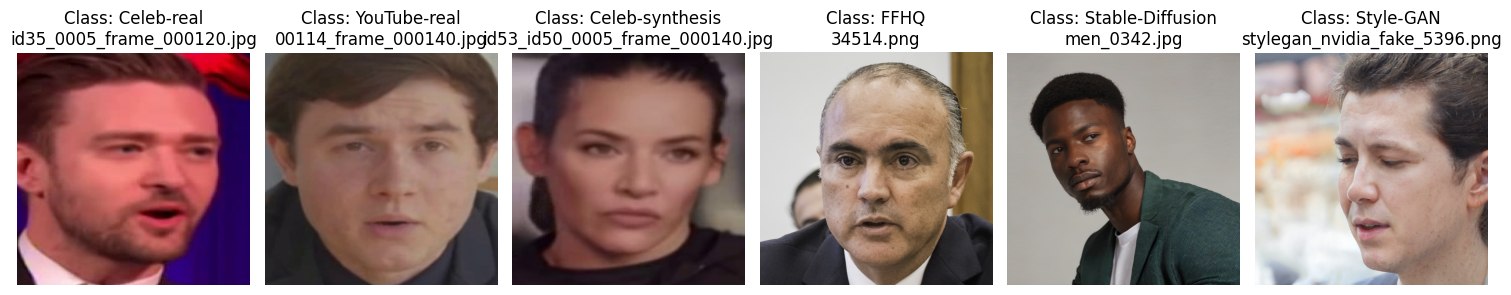

In [16]:
preview_local_images(PATHS_TO_PREVIEW)

In [17]:
# --- 3. Define Image Transforms ---
# Standard ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

source_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
])

target_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    normalize
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [18]:
source_video_real_paths = [
    REAL_CELEB_PATH,
    REAL_YOUTUBE_PATH
]
source_video_fake_paths = [
    FAKE_CELEB_PATH
]

# Target domain
target_image_real_paths = [
    FFHQ_REAL_PATH
]
target_image_fake_paths = [
    SD_PATH,
    GAN_PATH
]

In [19]:
loaders = get_data_mixed_structure(
    source_video_real_paths=source_video_real_paths,
    source_video_fake_paths=source_video_fake_paths,
    target_image_real_paths=target_image_real_paths,
    target_image_fake_paths=target_image_fake_paths,
    source_transform=source_transform,
    target_train_transform=target_train_transform,
    eval_transform=eval_transform,
    batch_size=32,
    random_seed=42
)


MEAN TEACHER DOMAIN ADAPTATION DATASET STATISTICS

--- SOURCE DOMAIN (Celeb-real, YouTube-real, Celeb-synthesis) ---
Source real folders: 890 total
  Train: 623 folders, 12810 frames
  Val:   133 folders, 2813 frames
  Test:  134 folders, 2729 frames

Source fake folders: 2361 total
  Train: 1652 folders, 31687 frames
  Val:   354 folders, 6783 frames
  Test:  355 folders, 6758 frames

--- TARGET DOMAIN (FFHQ, StableDiffusion, StyleGAN) ---
Target images: 14136 total
  Real: 4500 (Train: 3150, Val: 675, Test: 675)
  Fake: 9636 (Train: 6745, Val: 1445, Test: 1446)

--- COMBINED STATISTICS ---
Source train: 44497 (Real: 12810, Fake: 31687)
Source val:   9596 (Real: 2813, Fake: 6783)
Source test:  9487 (Real: 2729, Fake: 6758)
Target train: 9895 (Real: 3150, Fake: 6745) - labels not used for training
Target val:   2120 (Real: 675, Fake: 1445) - labels used for evaluation
Target test:  2121 (Real: 675, Fake: 1446) - labels used for evaluation

Batch size: 32



In [20]:
source_train_loader = loaders['source_train_loader']
source_val_loader = loaders['source_val_loader']
source_test_loader = loaders['source_test_loader']
target_train_loader = loaders['target_train_loader']
target_val_loader = loaders['target_val_loader']
target_test_loader = loaders['target_test_loader']

In [21]:
# --- 6. Initialize Model, Loss, and Optimizer ---
student_model = get_model(MODEL_NAME, pretrained=True, device=device)

# Loss Function (CrossEntropyLoss is standard for classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is a good default)
pretrain_optimizer = optim.Adam(student_model.parameters(), lr=PRETRAINING_LEARNING_RATE, weight_decay=1e-4)

Loading model: resnet34 (pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s]


Model resnet34 is ready and on device: cuda


### Pre-train on labeled data

In [22]:
# --- 7. Run Training ---
print(f"Starting training for {PRETRAINING_EPOCHS} epochs...")
model, history = main_training_loop(
    model=student_model,
    train_loader=source_train_loader,
    val_loader=source_val_loader,
    criterion=criterion,
    optimizer=pretrain_optimizer,
    num_epochs=PRETRAINING_EPOCHS,
    model_save_path=PRETRAINING_MODEL_SAVE_PATH,
    device=device
)
print("Training finished.")

Starting training for 3 epochs...

--- Epoch 1/3 ---


Training:   0%|          | 0/1391 [00:00<?, ?it/s]

Validating:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1 Complete: Train Loss: 0.1643, Train Acc: 93.43% | Val Loss: 0.0878, Val Acc: 96.72%
New best model saved with Val Acc: 96.72%

--- Epoch 2/3 ---


Training:   0%|          | 0/1391 [00:00<?, ?it/s]

Validating:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2 Complete: Train Loss: 0.0677, Train Acc: 97.49% | Val Loss: 0.0635, Val Acc: 97.97%
New best model saved with Val Acc: 97.97%

--- Epoch 3/3 ---


Training:   0%|          | 0/1391 [00:00<?, ?it/s]

Validating:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3 Complete: Train Loss: 0.0458, Train Acc: 98.27% | Val Loss: 0.0642, Val Acc: 97.41%

Training complete in 14m 39s
Best Val Acc: 97.9679
Training finished.


In [23]:
# --- 8. Run Final Testing ---
print(f"Loading best model from {PRETRAINING_MODEL_SAVE_PATH}.")
# Load the best model weights that were saved during training
student_model.load_state_dict(torch.load(PRETRAINING_MODEL_SAVE_PATH))

# Run evaluation on the test set
_ = test_model_source_domain(student_model, source_test_loader, device)

Loading best model from /kaggle/working/best_resnet34_pretraining.pth.

Starting evaluation on source domain test set...


Testing Source Domain:   0%|          | 0/297 [00:00<?, ?it/s]


SOURCE DOMAIN TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL     0.9433    0.9685    0.9557      2729
        FAKE     0.9871    0.9765    0.9818      6758

    accuracy                         0.9742      9487
   macro avg     0.9652    0.9725    0.9687      9487
weighted avg     0.9745    0.9742    0.9743      9487


PER-DOMAIN CLASSIFICATION REPORTS (SOURCE DOMAINS)

--- Celeb-real (video) ---
Samples: 1733
Accuracy: 95.38% (1653/1733)
All samples are REAL
Correct: 1653/1733

--- YouTube-real (video) ---
Samples: 996
Accuracy: 99.40% (990/996)
All samples are REAL
Correct: 990/996

--- Celeb-synthesis (video) ---
Samples: 6758
Accuracy: 97.65% (6599/6758)
All samples are FAKE
Correct: 6599/6758


In [24]:
_ = test_model_target_domain(student_model, target_test_loader, device)


Starting evaluation on test set...


Testing:   0%|          | 0/67 [00:00<?, ?it/s]


OVERALL TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL     0.3313    0.9674    0.4936       675
        FAKE     0.8533    0.0885    0.1604      1446

    accuracy                         0.3682      2121
   macro avg     0.5923    0.5280    0.3270      2121
weighted avg     0.6872    0.3682    0.2664      2121


PER-DOMAIN CLASSIFICATION REPORTS (TARGET DOMAINS)

--- FFHQ-real (image) ---
Samples: 675
Accuracy: 96.74% (653/675)
All samples are REAL
Correct: 653/675

--- StableDiffusion-fake (image) ---
Samples: 527
Accuracy: 16.89% (89/527)
All samples are FAKE
Correct: 89/527

--- StyleGAN-fake (image) ---
Samples: 919
Accuracy: 4.24% (39/919)
All samples are FAKE
Correct: 39/919


### Mean Teacher for Domain Adaptation

In [25]:
def update_ema_variables(student_model, teacher_model, alpha, global_step):
    """
    Update the teacher model's parameters using an exponential moving average of the student model's parameters.

    Args:
        student_model: The student model (current training model).
        teacher_model: The teacher model (EMA of the student).
        alpha: The EMA decay factor (e.g., 0.99).
        global_step: The current training step, used to adjust alpha dynamically.
    """
    alpha = min(1 - 1 / (global_step + 1), alpha)

    for teacher_param, student_param in zip(teacher_model.parameters(), student_model.parameters()):
        teacher_param.data.mul_(alpha).add_(student_param.data, alpha=1 - alpha)

In [26]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate model on a dataloader and return accuracy.

    Args:
        model: Model to evaluate
        dataloader: DataLoader to evaluate on
        device: Device to run evaluation on

    Returns:
        accuracy: Accuracy percentage
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [27]:
def train_mean_teacher(
    student_model,
    teacher_model,
    source_train_loader,
    target_train_loader,
    source_val_loader,
    target_val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    lambda_consistency=1.0,
    ema_decay=0.999,
    save_path='best_mean_teacher_model.pth',
    eval_frequency=1
):
    """
    Train Mean Teacher model for domain adaptation.

    Args:
        student_model: Student model (trainable)
        teacher_model: Teacher model (EMA of student)
        source_train_loader: DataLoader for source domain training
        target_train_loader: DataLoader for target domain training
        source_val_loader: DataLoader for source domain validation
        target_val_loader: DataLoader for target domain validation
        criterion: Loss function (e.g., CrossEntropyLoss)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Number of training epochs
        lambda_consistency: Weight for consistency loss
        ema_decay: EMA decay rate for teacher model
        save_path: Path to save best model
        eval_frequency: Evaluate every N epochs

    Returns:
        best_student_state: State dict of best student model
        training_history: Dictionary containing loss and accuracy history
    """

    print("\n" + "="*70)
    print("STARTING MEAN TEACHER DOMAIN ADAPTATION TRAINING")
    print("="*70)
    print(f"Epochs: {num_epochs}")
    print(f"Lambda consistency: {lambda_consistency}")
    print(f"EMA decay: {ema_decay}")
    print(f"Eval frequency: every {eval_frequency} epoch(s)")
    print("="*70 + "\n")

    history = {
        'train_source_loss': [],
        'train_target_loss': [],
        'train_total_loss': [],
        'source_val_acc': [],
        'target_val_acc': [],
    }

    best_target_val_acc = 0.0
    best_student_state = None
    best_epoch = 0
    global_step = 0

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.train()

        num_iters = max(len(source_train_loader), len(target_train_loader))
        source_iter = iter(source_train_loader)
        target_iter = iter(target_train_loader)

        epoch_source_loss = 0.0
        epoch_target_loss = 0.0
        epoch_total_loss = 0.0

        pbar = tqdm(range(num_iters), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i in pbar:
            source_images, source_labels, _ = next(source_iter)
            source_images, source_labels = source_images.to(device), source_labels.to(device)

            try:
                target_images1, target_images2, _, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_train_loader)
                target_images1, target_images2, _, _ = next(target_iter)

            target_images1, target_images2 = target_images1.to(device), target_images2.to(device)

            # Forward pass for student
            source_logits = student_model(source_images)
            source_loss = criterion(source_logits, source_labels)
            student_target_logits = student_model(target_images1)

            with torch.no_grad():
                teacher_logits = teacher_model(target_images2)

            cons_loss = F.mse_loss(
                F.softmax(student_target_logits, dim = 1),
                F.softmax(teacher_logits, dim = 1)
            )

            total_loss = source_loss + lambda_consistency * cons_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Update teacher model (EMA)
            global_step += 1
            update_ema_variables(student_model, teacher_model, ema_decay, global_step)

            epoch_source_loss += source_loss.item()
            epoch_target_loss += cons_loss.item()
            epoch_total_loss += total_loss.item()

            pbar.set_postfix({
                'S_Loss': f"{epoch_source_loss / (i+1):.4f}",
                'T_Loss': f"{epoch_target_loss / (i+1):.4f}",
                'Total Loss': f"{epoch_total_loss / (i+1):.4f}"
            })

        # Average losses for the epoch
        avg_source_loss = epoch_source_loss / num_iters
        avg_target_loss = epoch_target_loss / num_iters
        avg_total_loss = epoch_total_loss / num_iters

        history['train_source_loss'].append(avg_source_loss)
        history['train_target_loss'].append(avg_target_loss)
        history['train_total_loss'].append(avg_total_loss)

        print(f"\nEpoch [{epoch+1}/{num_epochs}] Training Summary:")
        print(f"  Source Loss: {avg_source_loss:.4f}")
        print(f"  Consistency Loss: {avg_target_loss:.4f}")
        print(f"  Total Loss: {avg_total_loss:.4f}")
        print(f"  Target data seen: {num_iters / len(target_train_loader):.1f}x")

        # ========================================
        # Validation
        # ========================================
        if (epoch + 1) % eval_frequency == 0:
            print(f"\n--- Validation (Epoch {epoch+1}) ---")

            source_val_acc = evaluate_model(student_model, source_val_loader, device)
            target_val_acc = evaluate_model(student_model, target_val_loader, device)

            print(f"  Source Val Accuracy: {source_val_acc:.2f}%")
            print(f"  Target Val Accuracy: {target_val_acc:.2f}%")

            history['source_val_acc'].append(source_val_acc)
            history['target_val_acc'].append(target_val_acc)

            if target_val_acc > best_target_val_acc:
                best_target_val_acc = target_val_acc
                best_student_state = copy.deepcopy(student_model.state_dict())
                best_epoch = epoch + 1

                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': best_student_state,
                    'source_val_acc': source_val_acc,
                    'target_val_acc': best_target_val_acc
                }, save_path)

                print(f"  New best model saved with Target Val Acc: {target_val_acc:.2f}%")

    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Best model from epoch {best_epoch}")
    print(f"Best target validation accuracy: {best_target_val_acc:.2f}%")
    print(f"Model saved to: {save_path}")
    print("="*70 + "\n")
    
    return best_student_state, history


In [28]:
ema_decay = 0.999
consistency_weight = 1.0
ADAPTATION_LEARNING_RATE = 2e-5
ADAPTATION_EPOCHS = 5
ADAPTATION_MODEL_SAVE_PATH = f"/kaggle/working/best_{MODEL_NAME}_adaptation.pth"

In [29]:
print(f"Loading best model from {PRETRAINING_MODEL_SAVE_PATH}.")
# Load the best model weights that were saved during training
student_model.load_state_dict(torch.load(PRETRAINING_MODEL_SAVE_PATH))

Loading best model from /kaggle/working/best_resnet34_pretraining.pth.


<All keys matched successfully>

In [30]:
teacher_model = copy.deepcopy(student_model)
for param in teacher_model.parameters():
    param.requires_grad = False

In [31]:
criterion = nn.CrossEntropyLoss()
adaptation_optimizer = optim.Adam(student_model.parameters(), lr=ADAPTATION_LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [32]:
best_state, history = train_mean_teacher(
    student_model=student_model,
    teacher_model=teacher_model,
    source_train_loader=source_train_loader,
    target_train_loader=target_train_loader,
    source_val_loader=source_val_loader,
    target_val_loader=target_val_loader,
    criterion=criterion,
    optimizer=adaptation_optimizer,
    device=device,
    num_epochs=ADAPTATION_EPOCHS,
    lambda_consistency=1.0,
    ema_decay=0.999,
    save_path=ADAPTATION_MODEL_SAVE_PATH,
    eval_frequency=1
)


STARTING MEAN TEACHER DOMAIN ADAPTATION TRAINING
Epochs: 5
Lambda consistency: 1.0
EMA decay: 0.999
Eval frequency: every 1 epoch(s)



Epoch 1/5:   0%|          | 0/1391 [00:00<?, ?it/s]


Epoch [1/5] Training Summary:
  Source Loss: 0.0324
  Consistency Loss: 0.0428
  Total Loss: 0.0751
  Target data seen: 4.5x

--- Validation (Epoch 1) ---
  Source Val Accuracy: 93.09%
  Target Val Accuracy: 55.05%
  New best model saved with Target Val Acc: 55.05%


Epoch 2/5:   0%|          | 0/1391 [00:00<?, ?it/s]


Epoch [2/5] Training Summary:
  Source Loss: 0.0228
  Consistency Loss: 0.0221
  Total Loss: 0.0449
  Target data seen: 4.5x

--- Validation (Epoch 2) ---
  Source Val Accuracy: 96.30%
  Target Val Accuracy: 54.01%


Epoch 3/5:   0%|          | 0/1391 [00:00<?, ?it/s]


Epoch [3/5] Training Summary:
  Source Loss: 0.0187
  Consistency Loss: 0.0143
  Total Loss: 0.0331
  Target data seen: 4.5x

--- Validation (Epoch 3) ---
  Source Val Accuracy: 93.91%
  Target Val Accuracy: 56.13%
  New best model saved with Target Val Acc: 56.13%


Epoch 4/5:   0%|          | 0/1391 [00:00<?, ?it/s]


Epoch [4/5] Training Summary:
  Source Loss: 0.0171
  Consistency Loss: 0.0105
  Total Loss: 0.0276
  Target data seen: 4.5x

--- Validation (Epoch 4) ---
  Source Val Accuracy: 94.62%
  Target Val Accuracy: 54.81%


Epoch 5/5:   0%|          | 0/1391 [00:00<?, ?it/s]


Epoch [5/5] Training Summary:
  Source Loss: 0.0131
  Consistency Loss: 0.0075
  Total Loss: 0.0207
  Target data seen: 4.5x

--- Validation (Epoch 5) ---
  Source Val Accuracy: 96.14%
  Target Val Accuracy: 53.35%

TRAINING COMPLETE
Best model from epoch 3
Best target validation accuracy: 56.13%
Model saved to: /kaggle/working/best_resnet34_adaptation.pth



In [33]:
student_model.load_state_dict(best_state)

<All keys matched successfully>

In [34]:
_ = test_model_source_domain(student_model, source_test_loader, device)


Starting evaluation on source domain test set...


Testing Source Domain:   0%|          | 0/297 [00:00<?, ?it/s]


SOURCE DOMAIN TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL     0.9982    0.8230    0.9022      2729
        FAKE     0.9333    0.9994    0.9652      6758

    accuracy                         0.9487      9487
   macro avg     0.9657    0.9112    0.9337      9487
weighted avg     0.9519    0.9487    0.9471      9487


PER-DOMAIN CLASSIFICATION REPORTS (SOURCE DOMAINS)

--- Celeb-real (video) ---
Samples: 1733
Accuracy: 75.65% (1311/1733)
All samples are REAL
Correct: 1311/1733

--- YouTube-real (video) ---
Samples: 996
Accuracy: 93.88% (935/996)
All samples are REAL
Correct: 935/996

--- Celeb-synthesis (video) ---
Samples: 6758
Accuracy: 99.94% (6754/6758)
All samples are FAKE
Correct: 6754/6758


In [35]:
_ = test_model_target_domain(student_model, target_test_loader, device)


Starting evaluation on test set...


Testing:   0%|          | 0/67 [00:00<?, ?it/s]


OVERALL TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL     0.3840    0.5200    0.4418       675
        FAKE     0.7316    0.6107    0.6657      1446

    accuracy                         0.5818      2121
   macro avg     0.5578    0.5653    0.5537      2121
weighted avg     0.6210    0.5818    0.5944      2121


PER-DOMAIN CLASSIFICATION REPORTS (TARGET DOMAINS)

--- FFHQ-real (image) ---
Samples: 675
Accuracy: 52.00% (351/675)
All samples are REAL
Correct: 351/675

--- StableDiffusion-fake (image) ---
Samples: 527
Accuracy: 44.21% (233/527)
All samples are FAKE
Correct: 233/527

--- StyleGAN-fake (image) ---
Samples: 919
Accuracy: 70.73% (650/919)
All samples are FAKE
Correct: 650/919


# GradCam

In [36]:
!pip install grad-cam
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.1 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00

In [37]:
def visualize_gradcam(model, test_dataset, target_layer, device):
    """
    Finds one correctly predicted FAKE image from each domain and visualizes with Grad-CAM.
    """
    import random

    # Inverse normalization transform for displaying images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Target class is 1 (FAKE)
    targets = [ClassifierOutputTarget(LABEL_FAKE)]

    # Define FAKE domains only
    fake_domains = {
        'Celeb-synthesis (video)': 'Celeb-DF/data/Celeb-synthesis',
        'StableDiffusion (image)': 'StableDiffusion-fake-v2',
        'StyleGAN (image)': 'stylegan_fake_dataset_nvidia',
    }

    print(f"Searching for correctly predicted FAKE images from each domain...")

    # Store one sample per domain: {domain_name: (image_tensor, rgb_img, path)}
    domain_samples = {}

    # Shuffle dataset to get random samples
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    model.eval()
    with torch.no_grad():
        for idx in tqdm(indices, desc="Finding samples"):
            # Unpack 3 values
            image_tensor, label, file_path = test_dataset[idx]

            # Only process FAKE images
            if label != LABEL_FAKE:
                continue

            # Check which domain this sample belongs to
            for domain_name, domain_pattern in fake_domains.items():
                if domain_pattern in file_path and domain_name not in domain_samples:
                    # Get model prediction
                    output = model(image_tensor.unsqueeze(0).to(device))
                    pred = torch.argmax(output, dim=1).item()

                    # Check if prediction was correct
                    if pred == LABEL_FAKE:
                        # Save the (unnormalized) tensor for visualization
                        rgb_img = inv_normalize(image_tensor).permute(1, 2, 0).numpy()
                        rgb_img = np.clip(rgb_img, 0, 1)

                        domain_samples[domain_name] = (image_tensor, rgb_img, file_path)
                        print(f"✓ Found sample for {domain_name}")
                        break

            # Stop when we have one sample from each domain
            if len(domain_samples) == len(fake_domains):
                break

    if len(domain_samples) == 0:
        print("Could not find any correctly predicted FAKE images.")
        return

    print(f"\nFound {len(domain_samples)}/{len(fake_domains)} domains with correct predictions.")
    print("Generating visualizations...")

    # ========================================
    # Create the visualization plot
    # ========================================
    num_samples = len(domain_samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    # Handle case where we only have 1 sample
    if num_samples == 1:
        axs = [axs]

    fig.suptitle("Grad-CAM Visualization for FAKE Images by Domain", fontsize=20, y=0.995)

    for i, (domain_name, (input_tensor, rgb_img, file_path)) in enumerate(domain_samples.items()):
        # Generate the CAM
        input_tensor_cam = input_tensor.unsqueeze(0)
        grayscale_cam = cam(input_tensor=input_tensor_cam, targets=targets)[0, :]

        # Create the overlay
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plot Original
        axs[i][0].imshow(rgb_img)
        axs[i][0].set_title(f"{domain_name}\nOriginal Image")
        axs[i][0].axis('off')

        # Plot Heatmap
        axs[i][1].imshow(grayscale_cam, cmap='jet')
        axs[i][1].set_title("Grad-CAM Heatmap")
        axs[i][1].axis('off')

        # Plot Overlay
        axs[i][2].imshow(visualization)
        axs[i][2].set_title("Overlay")
        axs[i][2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print file paths for reference
    print("\nSample file paths:")
    for domain_name, (_, _, file_path) in domain_samples.items():
        print(f"{domain_name}: {file_path}")

In [38]:
# For ResNet-50, 'layer4' is the last convolutional block
target_layer = student_model.layer4

# --- Run Visualization ---
visualize_gradcam(
    model=model,
    test_dataset=test_dataset,
    target_layer=target_layer,
    device=device
)

NameError: name 'test_dataset' is not defined

# Model testing